In [1]:
# load necessary packages
import pandas as pd
import os
from pandas import read_csv
from pandas import read_parquet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pyarrow
import fastparquet
from datetime import datetime, timezone, timedelta
import scipy.stats as s

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font


# define data directory
work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/data/INRIX'
os.chdir(work_dir)

# define states to pull data from
selected_state = 'CA'

# define unit conversion factor
meter_to_mile = 0.000621371

In [3]:
# data process function
def inrix_data_cleaning(data):
    
    # data filtering & cleaning
    data = data.loc[data['mode'] == 1] # vehicle (not walking mode) 
    data = data.loc[data['movement_type'] == 1] # moving trips
#     data = data.loc[data['vehicle_weight_class'] == 1] # LDVs
    data = data.dropna(subset = ['start_cbg', 'end_cbg']) # drop trips with unknown O-D
    
    # generate time-related attributes
    tz = data.start_tz.unique()[0]
#     print(tz)
    data.loc[:, 'start_date'] = data.loc[:, 'start_date'].str.split('.').str[0]
    data.loc[:, 'end_date'] = data.loc[:, 'end_date'].str.split('.').str[0]

    data['start_time'] = \
    pd.to_datetime(data['start_date'].astype(str), format='%Y-%m-%dT%H:%M:%S')
    data['start_time'] = data['start_time'].dt.tz_localize('utc').dt.tz_convert(tz)

    data['end_time'] = \
    pd.to_datetime(data['end_date'].astype(str), format='%Y-%m-%dT%H:%M:%S')
    data['end_time'] = data['end_time'].dt.tz_localize('utc').dt.tz_convert(tz)
    data.loc[:, 'start_hour'] = \
    data.loc[:, 'start_time'].dt.hour
    data.loc[:, 'end_hour'] = \
    data.loc[:, 'end_time'].dt.hour
    data.loc[:, 'dayofweek'] = \
    data.loc[:, 'start_time'].dt.dayofweek
    data = data.loc[data['dayofweek']<= 4] # select only weekday data
    data.loc[:, 'travel_time'] = data.loc[:, 'end_time'] - data.loc[:, 'start_time'] 
    
    # generate travel impedance
    data.loc[:, 'travel_time_h'] =  data.loc[:, 'travel_time']/ pd.Timedelta(hours=1)
    data.loc[:, 'trip_distance_mile'] = data.loc[:, 'trip_distance_m'] * meter_to_mile
    
    # generate O-D info
    data.loc[:, ['start_cbg', 'end_cbg']] = data.loc[:, ['start_cbg', 'end_cbg']].astype(int)
    data.loc[:, 'o_GEOID'] = data.loc[:, 'start_cbg'] / 10
    data.loc[:, 'd_GEOID'] = data.loc[:, 'end_cbg'] / 10
    data.loc[:, ['o_GEOID', 'd_GEOID']] = data.loc[:, ['o_GEOID', 'd_GEOID']].astype(int)
    return(data)

In [5]:
# processing INRIX data

list_of_inrix_folder = os.listdir(selected_state + '_trips') 
# path to INRIX data folder, this needs to be updated if directory name changes
inrix_trip_out = None

# define variables to keep
out_attr = ['trip_id', 'o_GEOID', 'd_GEOID', 'vehicle_weight_class', 
            'start_hour', 'travel_time_h', 'trip_distance_mile']

group_var = ['o_GEOID', 'd_GEOID', 'vehicle_weight_class', 'start_hour']
# loop through INRIX data folder and process each file
for folder in list_of_inrix_folder: # each folder is one day's trip
    if folder == '.DS_Store': # MAC system only, skip this file
        continue
    print(folder)
    list_of_inrix_trips = os.listdir(selected_state + '_trips/' + folder)
    trip_dir = selected_state + '_trips/' + folder
    for file in list_of_inrix_trips: 
        # loop through trip files under daily trip folder
        if file.endswith('.parquet'):
            # load Parquet data
            inrix_trips = read_parquet(trip_dir + '/' + file, engine = 'auto')
            # clean and format data, generate travel attributes
            inrix_trips = inrix_data_cleaning(inrix_trips)
            # keep essential variables
            inrix_trips = inrix_trips[out_attr]
            
            # generate skims
            od_skim = \
            inrix_trips.groupby(group_var).agg({'travel_time_h':'sum',
                                                'trip_distance_mile':'sum',
                                                'trip_id':'count'})
            od_skim = od_skim.reset_index()
            od_skim.columns = ['o_GEOID', 'd_GEOID', 'vehicle_weight_class', 'start_hour', 'travel_time_h', 'trip_distance_mile', 'trip_count']
            inrix_trip_out = pd.concat([inrix_trip_out, od_skim])            
#         break
#     break
print(len(inrix_trip_out))
inrix_trip_out.head(5)


inrix.trips.20200121.ca
inrix.trips.20200115.ca
inrix.trips.20200124.ca
inrix.trips.20200120.ca
inrix.trips.20200114.ca
inrix.trips.20200119.ca
inrix.trips.20200118.ca
inrix.trips.20200113.ca
inrix.trips.20200123.ca
inrix.trips.20200117.ca
inrix.trips.20200122.ca
inrix.trips.20200116.ca
79301181


,o_GEOID,d_GEOID,vehicle_weight_class,start_hour,travel_time_h,trip_distance_mile,trip_count
0,6001400100,6001400100,1,7,0.403333,10.358814,1
1,6001400100,6001400100,1,8,0.576944,7.997448,2
2,6001400100,6001400100,1,12,0.910556,25.158734,1
3,6001400100,6001400200,1,7,0.365278,5.379511,1
4,6001400100,6001400200,1,8,0.163333,2.283169,1


In [6]:
# generate travel time and distance skim
group_var = ['o_GEOID', 'd_GEOID', 'vehicle_weight_class', 'start_hour']

# aggregate travel skims from different days and trip files
travel_time_by_od = inrix_trip_out.groupby(group_var)[['trip_distance_mile', 
                                                       'travel_time_h', 'trip_count']].sum()
travel_time_by_od = travel_time_by_od.reset_index()

travel_time_by_od.columns = ['o_GEOID', 'd_GEOID', 'vehicle_weight_class', 
                             'start_hour', 'distance_mile', 'travel_time_h', 'trip_count']
print(len(travel_time_by_od))
print(travel_time_by_od.trip_count.sum())
travel_time_by_od.head(5)


21761130
97374835


,o_GEOID,d_GEOID,vehicle_weight_class,start_hour,distance_mile,travel_time_h,trip_count
0,6001400100,6001400100,1,0,14.838246,0.733056,2
1,6001400100,6001400100,1,4,31.644015,1.119167,3
2,6001400100,6001400100,1,5,68.881253,2.905278,7
3,6001400100,6001400100,1,6,6.287118,1.141389,6
4,6001400100,6001400100,1,7,285.969033,17.467222,58


In [7]:
# generate avg. travel time/dist per trip and writing output
output_dir = 'Skim/' # directory to output skims, can be changed
travel_time_by_od.loc[:, 'distance_mile'] = travel_time_by_od.loc[:, 'distance_mile'] / travel_time_by_od.loc[:, 'trip_count']
travel_time_by_od.loc[:, 'travel_time_h'] = travel_time_by_od.loc[:, 'travel_time_h'] / travel_time_by_od.loc[:, 'trip_count']

travel_time_by_od.to_csv(output_dir + selected_state + '_travel_time.csv', index = False)

inrix.trips.20200121.ca
930910


(0.0, 2.0)

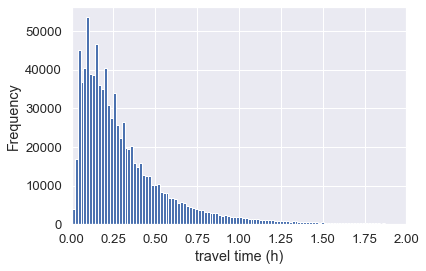

In [8]:
# fit survival function for travel time

list_of_inrix_folder = os.listdir(selected_state + '_trips')
inrix_trip_out = None
out_attr = ['trip_id', 'o_GEOID', 'd_GEOID', 'travel_time_h', 'trip_distance_mile']

for folder in list_of_inrix_folder:
    if folder == '.DS_Store':
        continue
    print(folder)
    list_of_inrix_trips = os.listdir(selected_state + '_trips/' + folder)
    trip_dir = selected_state + '_trips/' + folder
    for file in list_of_inrix_trips:
        if file.endswith('.parquet'):
#             print(file)
            inrix_trips = read_parquet(trip_dir + '/' + file, engine = 'auto')
            sample_inrix_trip_out = inrix_data_cleaning(inrix_trips)
            sample_inrix_trip_out = \
            sample_inrix_trip_out.loc[sample_inrix_trip_out['vehicle_weight_class'] == 1] # LDVs
            sample_inrix_trip_out = sample_inrix_trip_out[out_attr]
                     
        break
    break
print(len(sample_inrix_trip_out))
sample_inrix_trip_out.head(5)
sample_inrix_trip_out['travel_time_h'].plot(kind = 'hist',bins = 500)
plt.xlabel('travel time (h)')
plt.xlim([0, 2])

In [4]:
params = s.exponweib.fit(sample_inrix_trip_out['travel_time_h'], floc=0, f0=1)
shape = params[1]
scale = params[3]
print(params)
print('shape:', shape)
print('scale:',scale)

(1, 1.1603505204251645, 0, 0.34345185900749187)
shape: 1.1603505204251645
scale: 0.34345185900749187


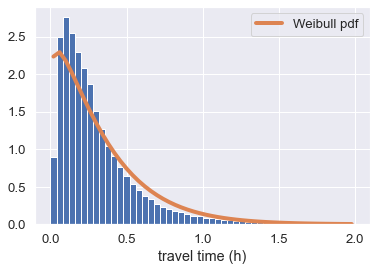

In [10]:
values,bins,hist = plt.hist(sample_inrix_trip_out['travel_time_h'],bins=50, range=(0,2), density = True)
center = (bins[:-1] + bins[1:]) / 2.

# Using all params and the stats function
plt.plot(center,s.exponweib.pdf(center,*params),lw=4,label='Weibull pdf')
# plt.plot(center,s.exponweib.sf(center,*params),lw=4,label='survival function')
plt.xlabel('travel time (h)')
plt.legend()
plt.savefig('Plot/' + selected_state+ '/fitted_travel_time_curve.png', dpi = 300)

In [7]:
#CA results for comparison
params = s.exponweib.fit(sample_inrix_trip_out['travel_time_h'], floc=0, f0=1)
shape = params[1]
scale = params[3]
print(params)
print('shape:', shape)
print('scale:',scale)

(1, 1.1883551257075007, 0, 0.34605314636038553)
shape: 1.1883551257075007
scale: 0.34605314636038553


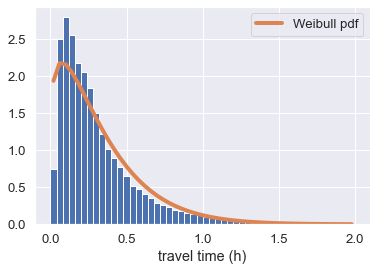

In [9]:
values,bins,hist = plt.hist(sample_inrix_trip_out['travel_time_h'],bins=50, range=(0,2), density = True)
center = (bins[:-1] + bins[1:]) / 2.

# Using all params and the stats function
plt.plot(center,s.exponweib.pdf(center,*params),lw=4,label='Weibull pdf')
# plt.plot(center,s.exponweib.sf(center,*params),lw=4,label='survival function')
plt.xlabel('travel time (h)')
plt.legend()
plt.savefig('Plot/' + selected_state+ '/fitted_travel_time_curve.png', dpi = 300)